In [1]:
import sys 
sys.path.append("..") 
from train import *
from utils.score import cal_all_score
from dataloader import Dataload
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline
import datetime

E:\anaconda\envs\DSIM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0]
detect set : [0]
use gpu: True


In [2]:
device = 'cuda:0'

In [3]:
batch_size = 10

In [4]:
parameter_path_dict = {
    921:r"H:/parameter_FPN/save_best/FL_DETR/best.pkl",
    922:r"H:/parameter_FPN/save_best/FL_DETR_2/best.pkl",
    923:r"H:\parameter_FPN\FL_DETR_reverse_1024/best.pkl",
    # 4:r"H:\parameter_FPN\GTU_gan/best.pkl",
    41:r"H:/parameter_FPN/FL_GTU/best.pkl",
    42:r"H:/parameter_FPN/gtu_pvt_test/best2.pkl",
    43:r"H:/parameter_FPN/GTU_pvt_mlp/best.pkl",
    # H:\parameter_FPN\gtu_pvt_test
    #4:r"H:/parameter_FPN/GTU_decode_2/best.pkl",
    # 4:r"H:/parameter_FPN/GTU_0/best.pkl",
    # 4:r"H:/parameter_FPN/GTU_0_1/best.pkl",
    4:r"H:/parameter_FPN/GTU_dsk/best.pkl",
    # 4:r"H:/parameter_FPN/GTU_d_2/best.pkl",
}

In [5]:
parameter_path = parameter_path_dict[42]
batch_size = 10
method_dict = {
    0: "Unet",
    1: "RESUNet",
    2: 'RU',
    4:"GTU",
    41:"FL_GTU",
    43:"GTU pvt mlp",
    5: "FL",
    8: "FL tiny",
    9: "FL FPN",
    91: "FL FPN 4 8",
    911: "FL FPN 911",
    92:"DETR",
    921:"FL_DETR B",
    922:"FL_DETR_2",
    923:"FL_DETR_reverse",
}
parameter_path

'H:/parameter_FPN/gtu_pvt_test/best2.pkl'

In [6]:
trainer = Train(
        1, (224),
        name = "GTU_pvt_4",
        method_type = 42,
        is_show = False,
        batch_size = batch_size,
        device_ = "cuda:0",
)

[1, 64, 128, 256, 512, 1024]
detype conv
sk: 1
detype conv
sk: 2
detype conv
sk: 3
detype conv
sk: 3
pvt Summary: 319 layers, 24849856 parameters, 24.849856 M, 24849856 gradients
build GT_U_DC_PVTNet model
start paramete k:0.5, pre:0.5, p:0.5


In [7]:
trainer.load_parameter( parameter_path )
parameter_path

'H:/parameter_FPN/gtu_pvt_test/best2.pkl'

In [8]:
all_dataloader = Dataload( r'H:\DATASET\teech\image/', (320,640), data_type = "val", data_aug = 1) # (320,640)
save_path = './test/'
save_path = save_path + trainer.name
all_dataloader.create_dir(save_path )
save_path = save_path + "/infers/"
print("验证集合大小: {} ".format( len( all_dataloader )))
all_dataloader.create_dir(save_path )
print( "save path:" , save_path)
print( "load parameter path:" , save_path)

H:\DATASET\teech\image//image/ 500 H:\DATASET\teech\image//image/ 500
total: 500
验证集合大小: 500 
save path: ./test/GTU_pvt_4/infers/
load parameter path: ./test/GTU_pvt_4/infers/


In [9]:
trainer.model.__class__.__name__

'GT_U_DC_PVTNet'

In [35]:
n_p = sum(x.numel() for x in trainer.model.up_list.parameters()) 
n_p/1e6    

12.53952

In [10]:
global device 
device = "cpu"

In [9]:
import torch

# inceference all

In [11]:
total = len(all_dataloader)
score_list = []
index = 0
start_time = datetime.datetime.now() 
for image_dict in all_dataloader.photo_set:
    image_path = image_dict["image"]
    image = all_dataloader.read_image_data(image_path, True)
    batch_image = all_dataloader.datagen_val( image )
    file_name = image_path.split("/")[-1]
    image_save_name = save_path + file_name
    # batch_image = batch_image.cpu()
    
    batch_image = torch.cat([batch_image, batch_image], 0).unsqueeze(1).to("cuda:0")
    out = trainer.predict_batch(batch_image)
    #     with torch.no_grad():
    #         out = trainer.model.forward_consist(batch_image, 1)
    mask = out["mask"].squeeze().cpu().numpy()
    mask = mask[0]
    # print(mask.shape)
    mask = (mask - np.min(mask))/(np.max(mask) - np.min(mask))
    mask[mask>=0.5] = 1
    mask[mask<0.5] = 0
    # mask = np.abs(mask + np.ones_like( mask ) * -1)
    imgan = np.array(mask * 255, dtype = np.uint8)
    imgan = cv2.cvtColor(imgan, cv2.COLOR_RGB2BGR)
    imGray = cv2.cvtColor(imgan, cv2.COLOR_BGR2GRAY)/255
    cv2.imwrite(image_save_name, imGray, [cv2.IMWRITE_PNG_BILEVEL, 1])
    if index % 100 == 0:
        print("ETA: ", index," / " ,np.round(( total - index )*(datetime.datetime.now() - start_time).seconds / 60, 3) , end='\r')
        start_time = datetime.datetime.now() 
    index += 1
print("done  500  /  0 ")

done  500  /  0 3.333


In [19]:
edge = out["edge"].squeeze().cpu().numpy()
edge[ edge >= 0.5 ] = 1
edge[ edge < 0.5 ] = 0
edge = np.array(edge * 255, dtype = np.uint8)
edge = cv2.cvtColor(edge, cv2.COLOR_RGB2BGR)
edge = cv2.cvtColor(edge, cv2.COLOR_BGR2GRAY)/255

In [30]:
add = mask + edge
mask1 = np.array((add - np.min(add))/(np.max(add) - np.min(add)) * 255, dtype = np.uint8)
mask1[mask1 >= 0.53 ] = 1
mask1[mask1< 0.53] = 0

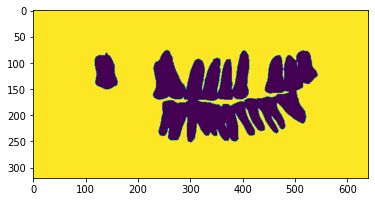

In [38]:
mask_origin = (mask_origin - np.min(mask_origin))/(np.max(mask_origin) - np.min(mask_origin))
mask_origin[mask_origin>0.5] = 1
mask_origin[mask_origin<0.5] = 0
plt.imshow(mask_origin)
plt.show()

In [39]:
mask_origin

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

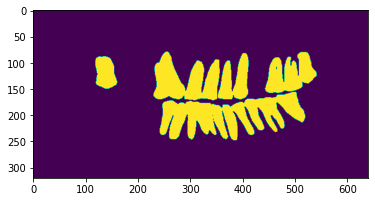

In [41]:
mask_origin = out["mask"][0].squeeze().cpu().numpy()
# mask_origin[mask_origin]=0
mask_origin[mask_origin>0] = 1
mask_origin = mask_origin + np.ones_like( mask_origin ) * -1
plt.imshow(np.abs(mask_origin))
plt.show()

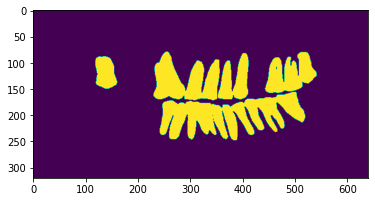

In [27]:
mask_origin = out["mask"][0].squeeze().cpu().numpy()
# mask_origin[mask_origin]=0
mask_origin[mask_origin>0]=1
mask_origin[mask_origin==1] = 2
mask_origin[mask_origin==0] = 1
mask_origin[mask_origin==2] = 0
# mask_origin = mask_origin + -1
plt.imshow(mask_origin)
plt.show()

In [37]:
mask_origin[mask_origin<0.2]=0
mask_origin[mask_origin>0.53]=1

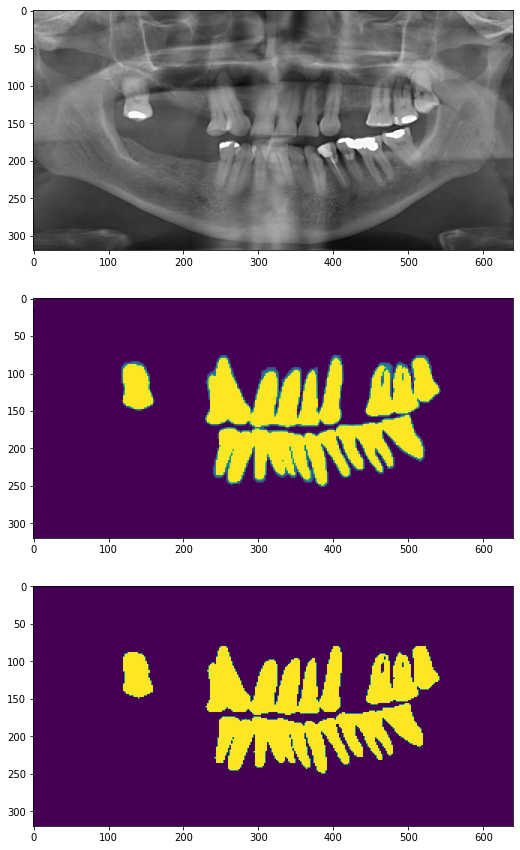

In [38]:
plt.figure(figsize=(20,15))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(311)
plt.imshow( image )
# plt.subplot(142)
# plt.imshow( gt )
plt.subplot(312)
plt.imshow( mask_origin)
plt.subplot(313)
plt.imshow( mask )
plt.show()

In [83]:
copy = out["mask"].squeeze().cpu().numpy()

In [82]:
copy 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

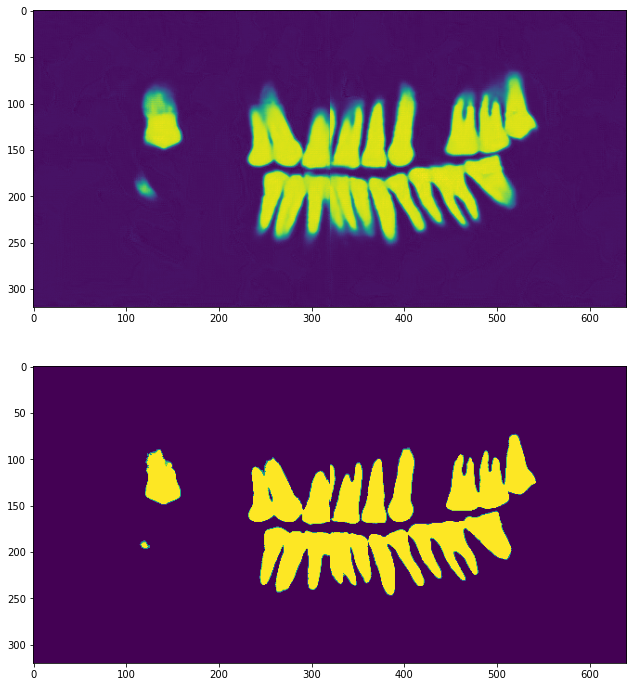

In [87]:
plt.figure(figsize=(12,12))

copy = out["mask"].squeeze().cpu().numpy()
plt.subplot(211)
plt.imshow(copy)
copy[copy >= 0.53 ] = 1
copy[copy < 0.5] = 0
plt.subplot(212)
plt.imshow(copy)
plt.show()

In [47]:
def cal(mask, gt, left, right, middle, middle_value):
    if left >= right :
        return  middle_value
    
    left_middle =  np.round(((left + middle)/2), 3)
    right_middle =  np.round((right + middle)/2, 3)

    left_value = cal_value(mask, gt, left_middle)
    right_value = cal_value(mask, gt, right_middle)
    
    max_v = torch.max([left_value, right_value, middle_value])
    if max_v == left_value:
        return cal(mask, gt, left, middle, left_middle, left_value)
    if max_v == right_value:
        return cal(mask, gt, middle, right, right_middle, right_value)
    if max_v == middle_value:
        return middle_value

In [131]:
import torch
def cal_dice(mask, gt):
    union = mask * gt
    dice = 2* torch.sum(union, [1,2,3])/(torch.sum(mask, [1,2,3])+torch.sum(gt, [1,2,3]))
    return torch.mean(dice)

def cal_iou_1(mask, gt):
    score = torch.sum(mask == gt, [1,2,3])/(320*640)
    return torch.mean(score)

def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

def cal_iou(mask, gt):
    union = mask * gt
    incorporate = (mask + gt) /2
    return torch.mean(torch.mean(union/incorporate, [1,2,3]))

def cal_Hausdorff(mask, gt):
    return torch.mean(torch.sum(torch.abs(mask - gt), [1,2,3]))

def cal_all_score(mask, gt):
    dice = dice_coeff(mask, gt)
    iou = cal_iou_1(mask, gt)
    hausdorff = cal_Hausdorff(mask, gt)
    score = 0.4 * dice + 0.3 * iou # + 0.3 * hausdorff
    return iou # [score, dice, iou, hausdorff]
def cal_value(mask, gt, thera = 0.5):
    mask = mask.clone()
    mask[ mask >= thera ] = 1
    mask[ mask < thera ] = 0
    value = cal_all_score( mask, gt )
    return value

# find best thera 

In [126]:
save_path = save_path + trainer.name + "/"
all_dataloader = Dataload( r'H:/DATASET/teech/train/', (320,640))
print("验证集合大小: {} ".format( len( all_dataloader )))
all_dataloader.create_dir(r"../perdict/FL_FPN_train" )
print( "save path:" , save_path)
print( "load parameter path:" , save_path)
total = len( all_dataloader )

total: 2000
验证集合大小: 2000 
save path: ../predict/FL_FPN_train/FL_FPN_train/FL_FPN_train/FL_FPN_train/
load parameter path: ../predict/FL_FPN_train/FL_FPN_train/FL_FPN_train/FL_FPN_train/


In [127]:
label_list = []
for image_dict in all_dataloader.photo_set:
    image_gt = all_dataloader.read_image_data(image_dict["gt"], True)
    batch_image_gt = all_dataloader.datagen_val( image_gt )
    label_list.append( batch_image_gt )

In [54]:
mask_list = []
label_list = []
index = 0
start_time = datetime.datetime.now() 
for image_dict in all_dataloader.photo_set:
    image_path = image_dict["image"]
    image = all_dataloader.read_image_data(image_path, True)
    image_gt = all_dataloader.read_image_data(image_dict["gt"], True)
    batch_image = all_dataloader.datagen_val( image )
    batch_image_gt = all_dataloader.datagen_val( image_gt )
    file_name = image_path.split("/")[-1]
    image_save_name = save_path + file_name
    out = trainer.predict_batch(batch_image.unsqueeze(0))
    mask = out['cmask']
    # mask = (mask - torch.min(mask))/( torch.max(mask) - torch.min(mask)) * 255
    mask_list.append( mask.cpu() )
    label_list.append( batch_image_gt )
    if index % 100 == 0:
        print("ETA: ", index," / " ,( total - index )*(datetime.datetime.now() - start_time).seconds / 60)  
        start_time = datetime.datetime.now() 
    index += 1

ETA:  0.0
ETA:  253.33333333333334
ETA:  240.0
ETA:  226.66666666666666
ETA:  213.33333333333334
ETA:  200.0
ETA:  186.66666666666666
ETA:  151.66666666666666
ETA:  140.0
ETA:  128.33333333333334
ETA:  116.66666666666667
ETA:  105.0
ETA:  93.33333333333333
ETA:  81.66666666666667
ETA:  70.0
ETA:  58.333333333333336
ETA:  46.666666666666664
ETA:  35.0
ETA:  23.333333333333332
ETA:  11.666666666666666


In [70]:
gt_object = torch.cat(label_list, 0).unsqueeze(1)
mask_object = torch.cat( mask_list, dim = 0 )
mask_object.shape, gt_object.shape

In [132]:
middle_value = cal_value(mask_object, gt_object, 0.3)
middle_value

tensor(0.9428)

In [133]:
middle_value = cal_value(mask_object, gt_object, 0.5)
middle_value

tensor(0.9533)

In [140]:
middle_value = cal_value(mask_object, gt_object, 0.55)
middle_value

tensor(0.9535)

In [138]:
middle_value = cal_value(mask_object, gt_object, 0.57)
middle_value

tensor(0.9535)

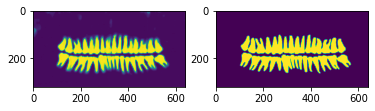

In [129]:
i = 3
mask_normal = (mask_object[i]  - torch.min(mask_object[i] ))/( torch.max(mask_object[i] ) - torch.min(mask_object[i] )) 

plt.subplot(121)
plt.imshow( mask_normal.squeeze().numpy() )
plt.subplot(122)
plt.imshow( gt_object[i].squeeze().numpy() )
plt.show()

# inference once

In [9]:
image_object = all_dataloader.photo_set[0]

In [10]:
image_path = image_object["image"]

In [11]:
image = all_dataloader.read_image_data(image_path, True)
batch_image = all_dataloader.datagen_val( image )

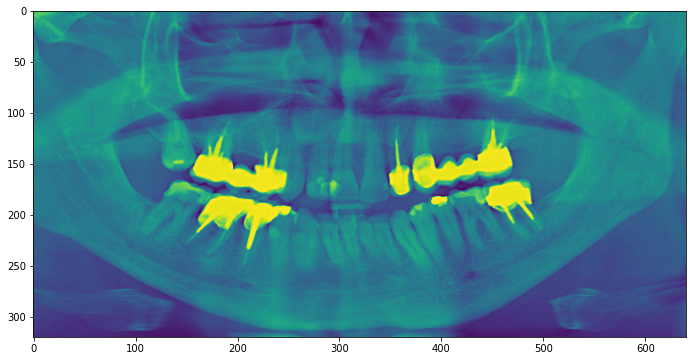

In [21]:
plt.figure(figsize=(12,6))
# plt.subplot(121)
plt.imshow(batch_image.squeeze().numpy())
# plt.subplot(122)
# plt.imshow(batch_image_gt.squeeze().numpy())
plt.show()

In [23]:
out = trainer.predict_batch(batch_image.unsqueeze(0))

In [110]:
cmask = out['cmask'].squeeze().cpu().numpy()
cmask[cmask >= 0.8] = 1
cmask[cmask < 0.8] = 0
imgan = np.array((cmask - np.min(cmask))/(np.max(cmask) - np.min(cmask)) * 255, dtype = np.uint8)
imgan = cv2.cvtColor(imgan, cv2.COLOR_RGB2BGR)

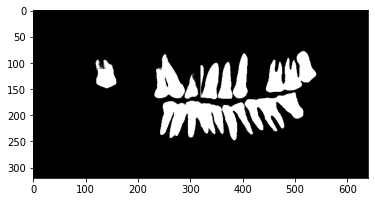

In [16]:
plt.imshow(imgan)
plt.show()

In [38]:
cv2.imwrite( "./test.png", imgan)

True

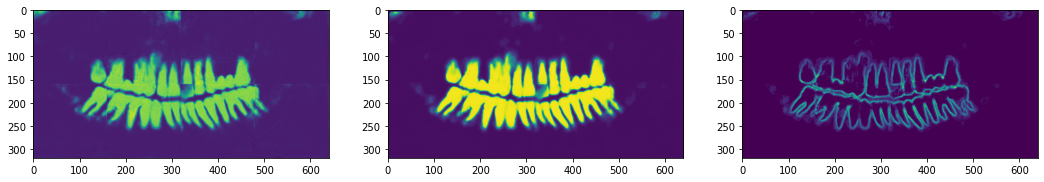

In [27]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(out['mask'].squeeze().cpu().numpy())
plt.subplot(132)
plt.imshow(out['cmask'].squeeze().cpu().numpy())
plt.subplot(133)
plt.imshow(out['edge'].squeeze().cpu().numpy())
plt.show()

# read

In [10]:
image = cv2.imread(r"H:/program/outpage/AITOOTH/test/test/FL_DETR_reverse_1024/infers/498.png", 0)
image.shape

(320, 640)

In [41]:
image[0:67,:] = 0
image[-20:, :] = 0
image[:, 0:50] = 0
image[:, -50:] = 0

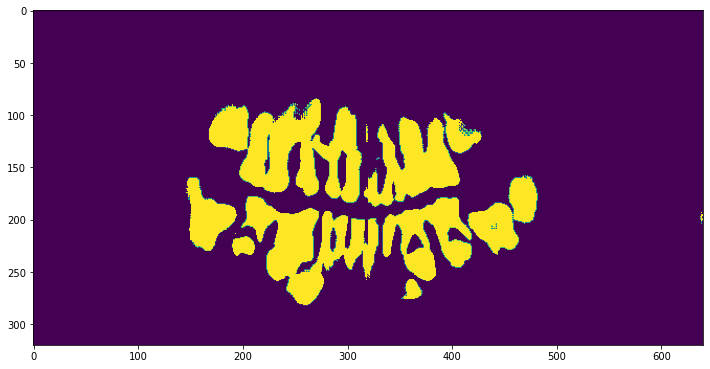

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

In [22]:
kernel = np.ones((3,3), np.uint8)
binary_dilation =cv2.dilate(image, kernel)
binary_erosion =cv2.erode(binary_dilation, kernel)

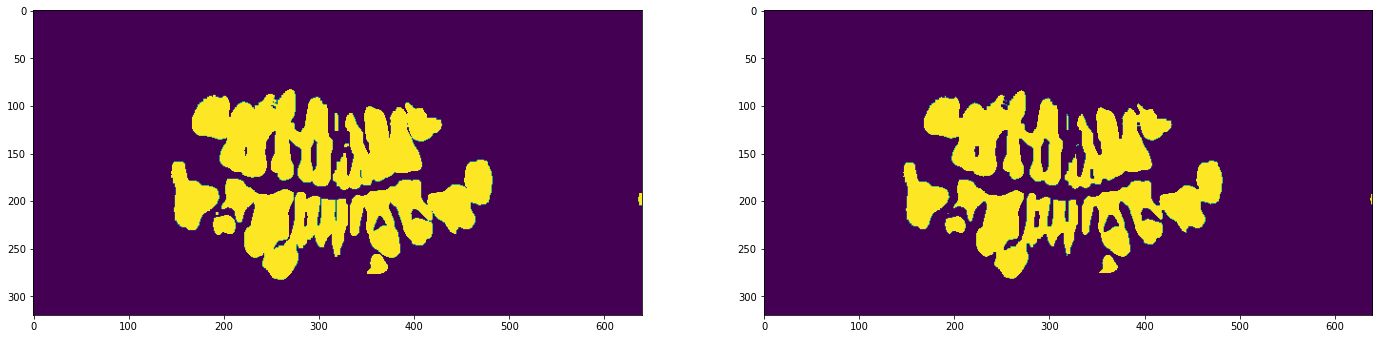

In [23]:
plt.figure(figsize=(24,12))
plt.subplot(121)
plt.imshow(binary_dilation)
plt.subplot(122)
plt.imshow(binary_erosion)
plt.show()

# tuning

In [10]:
save_path.split("infers/")[0]

'./test/FL_GTU/'

In [11]:
file_path = save_path
save_file_path = save_path.split("infers/")[0] + "tuning/"
all_dataloader.create_dir( save_file_path )
save_file_path = save_file_path + "infers/"
all_dataloader.create_dir( save_file_path )
file_name_list = os.listdir(file_path)
print(save_file_path, len(file_name_list))

./test/FL_GTU/tuning/infers/ 500


In [12]:
kernel = np.ones((3,3), np.uint8)
for file_name in file_name_list:
    image = cv2.imread(file_path + file_name, 0)
    image_save_name = save_file_path + file_name
    image[0:30,:] = 0
    image[-30:, :] = 0
    image[:, 0:30] = 0
    image[:, -30:] = 0
    binary_dilation =cv2.dilate(image, kernel)
    image = cv2.erode(binary_dilation, kernel)
    cv2.imwrite(image_save_name, image, [cv2.IMWRITE_PNG_BILEVEL, 1])

# cal HD

In [8]:
import numpy as np
from hausdorff import hausdorff_distance
import medpy.metric as mc
image = cv2.imread(r"H:/program/outpage/AITOOTH/test/test/FL_DETR_reverse_1024/infers/498.png", 0)
image.shape
kernel = np.ones((3,3), np.uint8)
binary_dilation =cv2.dilate(image, kernel)
binary_erosion =cv2.erode(binary_dilation, kernel)

In [3]:
hausdorff_distance(binary_dilation, binary_erosion, distance="manhattan")

11475.0

In [13]:
a = torch.zeros((2,1,60,60))
b = torch.zeros((2,1,60,60))

In [7]:
11475.0 / (320*640)

0.0560302734375

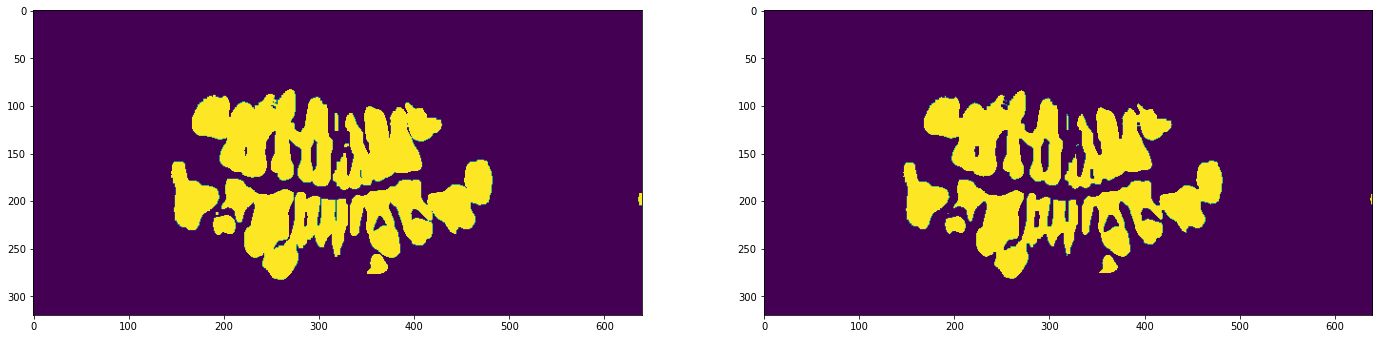

In [4]:
plt.figure(figsize=(24,12))
plt.subplot(121)
plt.imshow(binary_dilation)
plt.subplot(122)
plt.imshow(binary_erosion)
plt.show()

In [20]:
import cv2 as cv
import numpy as np

import torch
from torch import nn

from scipy.ndimage.morphology import distance_transform_edt as edt
from scipy.ndimage import convolve

"""
Hausdorff loss implementation based on paper:
https://arxiv.org/pdf/1904.10030.pdf

copy pasted from - all credit goes to original authors:
https://github.com/SilmarilBearer/HausdorffLoss
"""


class HausdorffDTLoss(nn.Module):
    """Binary Hausdorff loss based on distance transform"""

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        # pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error * distance
        loss = dt_field.mean()

        if debug:
            return (
                loss.cpu().numpy(),
                (
                    dt_field.cpu().numpy()[0, 0],
                    pred_error.cpu().numpy()[0, 0],
                    distance.cpu().numpy()[0, 0],
                    pred_dt.cpu().numpy()[0, 0],
                    target_dt.cpu().numpy()[0, 0],
                ),
            )

        else:
            return loss


class HausdorffERLoss(nn.Module):
    """Binary Hausdorff loss based on morphological erosion"""

    def __init__(self, alpha=2.0, erosions=10, **kwargs):
        super(HausdorffERLoss, self).__init__()
        self.alpha = alpha
        self.erosions = erosions
        self.prepare_kernels()

    def prepare_kernels(self):
        cross = np.array([cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))])
        bound = np.array([[[0, 0, 0], [0, 1, 0], [0, 0, 0]]])

        self.kernel2D = cross * 0.2
        self.kernel3D = np.array([bound, cross, bound]) * (1 / 7)

    @torch.no_grad()
    def perform_erosion(
        self, pred: np.ndarray, target: np.ndarray, debug
    ) -> np.ndarray:
        bound = (pred - target) ** 2

        if bound.ndim == 5:
            kernel = self.kernel3D
        elif bound.ndim == 4:
            kernel = self.kernel2D
        else:
            raise ValueError(f"Dimension {bound.ndim} is nor supported.")

        eroted = np.zeros_like(bound)
        erosions = []

        for batch in range(len(bound)):

            # debug
            erosions.append(np.copy(bound[batch][0]))

            for k in range(self.erosions):

                # compute convolution with kernel
                dilation = convolve(bound[batch], kernel, mode="constant", cval=0.0)

                # apply soft thresholding at 0.5 and normalize
                erosion = dilation - 0.5
                erosion[erosion < 0] = 0

                if erosion.ptp() != 0:
                    erosion = (erosion - erosion.min()) / erosion.ptp()

                # save erosion and add to loss
                bound[batch] = erosion
                eroted[batch] += erosion * (k + 1) ** self.alpha

                if debug:
                    erosions.append(np.copy(erosion[0]))

        # image visualization in debug mode
        if debug:
            return eroted, erosions
        else:
            return eroted

    def forward(
        self, pred: torch.Tensor, target: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        # pred = torch.sigmoid(pred)

        if debug:
            eroted, erosions = self.perform_erosion(
                pred.cpu().numpy(), target.cpu().numpy(), debug
            )
            return eroted.mean(), erosions

        else:
            eroted = torch.from_numpy(
                self.perform_erosion(pred.cpu().numpy(), target.cpu().numpy(), debug)
            ).float()

            loss = eroted.mean()

            return loss

C:\Users\HP\AppData\Local\Temp\ipykernel_21348\2522006253.py:7: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt as edt


In [21]:
hd = HausdorffDTLoss()

In [28]:
bd = torch.from_numpy(binary_dilation).unsqueeze(0).unsqueeze(0)
be = torch.from_numpy(binary_erosion).unsqueeze(0).unsqueeze(0)
bd.shape, be.shape

(torch.Size([1, 1, 320, 640]), torch.Size([1, 1, 320, 640]))

In [29]:
hd(bd, be)

tensor(0.0417)

# RV

In [13]:
q = torch.zeros((64, 256, 256))
q.shape

torch.Size([64, 256, 256])

In [25]:
q1 = q[torch.arange(64)[:,None], [0,1,2,3], :]
q1.shape

torch.Size([64, 4, 256])

In [32]:
import math

In [100]:
B = np.random.random((14, 14)) * 0.1
A = np.random.random((14, 14))
A.shape, B.shape

((14, 14), (14, 14))

In [127]:
B = np.ones((14, 14)) * 0.1
A = np.ones((14, 14)) * 0.9

In [128]:
A[np.eye(14,dtype=bool)] = 0
B[np.eye(14,dtype=bool)] = 0

In [115]:
# B = np.dot(Q,data.T)
# A = data.T
RV = np.trace(A.T.dot(A).dot(B.T).dot(B))/(0.0005 + math.sqrt( np.trace(  A.T.dot(A).dot(A.T).dot(A) ) * np.trace( B.T.dot(B).dot(B.T).dot(B) )))
print('RV系数为：',RV)

RV系数为： 0.999991865434768


In [129]:
c = np.trace(A.dot(A.T).dot( B.dot(B.T) ))

In [130]:
c/math.sqrt( np.trace( A.dot(A.T) ** 2 *  B.dot(B.T)  ** 2))

45.18770844026989

# JS

In [137]:
import torch.nn.functional as F

In [199]:
P = torch.randn((14,14)) 
Q = torch.randn((14,14))
# P = torch.ones((14,14)) * 0.2
# Q  = torch.ones((14,14)) * 0.1
M = (P + Q)/2

In [200]:
divergence = F.kl_div(Q.softmax(-1).log(), P.softmax(-1), reduction='sum')
divergence

tensor(12.8928)

In [201]:
divergence1 = F.kl_div(M.softmax(-1).log(), Q.softmax(-1), reduction='sum')
divergence2 = F.kl_div(M.softmax(-1).log(), P.softmax(-1), reduction='sum')
js = 0.5 * divergence1 + 0.5 * divergence2
js

tensor(3.0260)

In [157]:
from scipy import stats

In [179]:
0.5*stats.entropy(P.numpy(), M.numpy())+0.5*stats.entropy(Q.numpy(), M.numpy())

array([-1.0430812e-07, -1.0430812e-07, -1.0430812e-07, -1.0430812e-07,
       -1.0430812e-07, -1.0430812e-07, -1.0430812e-07, -1.0430812e-07,
       -1.0430812e-07, -1.0430812e-07, -1.0430812e-07, -1.0430812e-07,
       -1.0430812e-07, -1.0430812e-07], dtype=float32)

In [208]:
Q = torch.randn((2,14,14))

In [204]:
a = [ [1,torch.tensor(3), ], [2,torch.tensor(-1), ] , [3,torch.tensor(30), ]  ] 

In [206]:
sorted(a, key = lambda x:x[-1])

[[2, tensor(-1)], [1, tensor(3)], [3, tensor(30)]]

In [207]:
a[:2]

[[1, tensor(3)], [2, tensor(-1)]]

In [209]:
Q[:,3,:].shape

torch.Size([2, 14])

In [229]:
f = torch.randn((2,14,14*14))

In [230]:
f_norm = f.clone() * 2      #(B,C,HW)   
fd = f.transpose(1, 2)

In [231]:
fd.shape, f_norm.shape

(torch.Size([2, 196, 14]), torch.Size([2, 14, 196]))

In [232]:
bilinear.shape

torch.Size([2, 14, 14])

In [246]:
torch.einsum("bcd,bae->bce",f_norm, fd).shape

torch.Size([2, 14, 14])

In [281]:
x[:,:,:3,:3]

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [275]:
x = torch.ones((2,4,3,5))

In [277]:
bs, heads, length, _  =  x.shape
col_pad  =  torch.zeros((bs, heads, length, 1), dtype = x.dtype)
x  =  torch.cat([x, col_pad], dim = 3)
print("x:",x.shape)
flat_x  =  torch.reshape(x, [bs, heads, -1])
print( flat_x.shape  )
flat_pad  =  torch.zeros((bs, heads, length - 1), dtype = x.dtype)
print( flat_pad.shape  )
flat_x_padded  =  torch.cat([flat_x, flat_pad], dim = 2)
print( flat_x_padded.shape  )
final_x  =  torch.reshape(
    flat_x_padded, [bs, heads, length + 1, 2 * length - 1])

print( final_x.shape )
final_x  =  final_x[:, :, :length, length - 1:]

x: torch.Size([2, 4, 3, 6])
torch.Size([2, 4, 18])
torch.Size([2, 4, 2])
torch.Size([2, 4, 20])
torch.Size([2, 4, 4, 5])


In [280]:
x

tensor([[[[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]]],


        [[[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]],

         [[1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 0.]]]])

In [278]:
final_x.shape

torch.Size([2, 4, 3, 3])

In [279]:
final_x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [288]:
bs, length, _  =  x.shape
col_pad  =  torch.zeros((bs, length, 1), dtype = x.dtype)
x  =  torch.cat([x, col_pad], dim = -1)
flat_x  =  torch.reshape(x, [bs, -1])
flat_pad  =  torch.zeros((bs, length - 1), dtype = x.dtype)
flat_x_padded  =  torch.cat([flat_x, flat_pad], dim = 1)
final_x  =  torch.reshape(
    flat_x_padded, [bs, length + 1, 2 * length - 1])
final_x  =  final_x[:, :length, length - 1:]

In [289]:
final_x.shape

torch.Size([2, 4, 4])

In [ ]:
def add(x, y): #x是旋转图 y是要被贴的图
    w,h = x.shape
    mask = x[x == 0]
    y[:w, :h] *=  mask
    y[:w, :h] +=  x

In [168]:
import torch.nn as nn
import torch.nn.functional as F
class Rel(nn.Module):
    def __init__(self, C):
        super(Rel, self).__init__()
        self.rel_emb_w  =  nn.Parameter(torch.Tensor(2 * C - 1, 2 * C - 1))
        self.rel_emb_h  =  nn.Parameter(torch.Tensor(2 * C - 1, 2 * C - 1))
        nn.init.normal_(self.rel_emb_w, std = C ** -0.5)
        nn.init.normal_(self.rel_emb_h, std = C ** -0.5)

    def forward(self, q, k):
        b, c, hw  =  q.shape
        logits  =  torch.einsum('bcd,bae->bca', q, k)
        logits +=  self.relative_logits(logits)
        weights  =  torch.reshape(logits, [b, c, c])
        attn_out  =  F.softmax(weights, dim = -1)
        # print(attn_out.shape)
        return attn_out
    
    def relative_logits(self, q):
        # Relative logits in width dimension.
        rel_logits_w  =  self.relative_logits_1d(q, self.rel_emb_w, transpose_mask = [0, 1, 2])
        # Relative logits in height dimension
        rel_logits_h  =  self.relative_logits_1d(q.permute(0, 2, 1), self.rel_emb_h,
                                               transpose_mask = [0, 2, 1])
        return rel_logits_h + rel_logits_w
    
    def relative_logits_1d(self, q, rel_k, transpose_mask):
        bs, c, hw  =  q.shape
        rel_logits  =  torch.einsum('bcd,ae->bca', q, rel_k) # B C 2*C - 1
        rel_logits  =  self.rel_to_abs(rel_logits)
        return rel_logits
    
    def rel_to_abs(self, x):
        """
        Converts relative indexing to absolute.
        Input: [bs, length, 2*length - 1]
        Output: [bs, length, length]
        """
        bs, length, _  =  x.shape
        col_pad  =  torch.zeros((bs, length, 1), dtype = x.dtype).to(x.device)
        x  =  torch.cat([x, col_pad], dim = -1)
        flat_x  =  torch.reshape(x, [bs, -1]).to(x.device)
        flat_pad  =  torch.zeros((bs, length - 1), dtype = x.dtype).to(x.device)
        flat_x_padded  =  torch.cat([flat_x, flat_pad], dim = 1)
        final_x  =  torch.reshape(
            flat_x_padded, [bs, length + 1, 2 * length - 1]
            )
        final_x  =  final_x[:, :length, length - 1:]
        return final_x

In [169]:
x = torch.ones((2,2048,196))

In [170]:
a = Rel(2048)

In [173]:
a(x, x).shape

torch.Size([2, 2048, 2048])


torch.Size([2, 2048, 2048])

In [23]:
a = [0.08281238946844549, 0.08425957694941875, 0.06964543724761289, 0.06901609926831488, 0.0704098698847434, 0.0690968977470024, 0.06659986977191533, 0.06584206384186651, 0.06465968811044506, 0.0666486796941243, 0.0665418252933259, 0.06384202019841063, 0.06224826569942867, 0.060314475686526765, 0.061712307161560245, 0.060794119522267695, 0.057252797645096686, 0.0590185840048042, 0.05638533874469645, 0.05609181296883845, 0.05409530900857028, 0.05358101025808091, 0.05326856745808732, 0.053530185757314455, 0.0514902914417725, 0.05219978422803037, 0.05165147518410402, 0.051671989335148945, 0.049635409067074455, 0.05143959893315446, 0.049273565192432964, 0.04867574725957478, 0.04957775786226871, 0.04819628399084596, 0.05025532257323172, 0.048629944669265374, 0.05002789674144165, 0.051051346767766806, 0.05067387741862559, 0.049976930095284595, 0.051094317918314654, 0.05122654892358126, 0.05176127460949561, 0.05177509704349088, 0.052118674651080485]

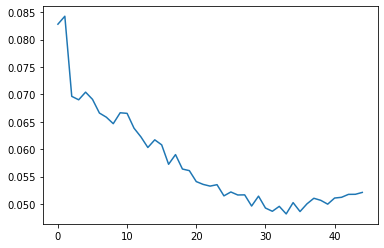

In [24]:
plt.plot(a)
plt.show()

In [27]:
c= [0.18913292082456443, 0.13369880387416253, 0.11356467209183253, 0.09882337571336673, 0.0885934689297126, 0.08130043802353051, 0.08528797013255265, 0.07144090590568689, 0.07134209429988494, 0.07175072024648006, 0.06636022862333518, 0.06523667920667392, 0.06384886844226947, 0.06148792445086516, 0.06018182893212025, 0.05947766567652042, 0.05897362673511872, 0.062188414856791496, 0.05645033401938585, 0.06082771431941252, 0.0567996663829455, 0.05538803138411962, 0.05469225203761688, 0.05491906848664467, 0.056295461093003936, 0.05534610295524964, 0.05850336256508644, 0.05411927946485006, 0.053604298629439794, 0.061276061890216976, 0.052954136608884886, 0.05462167197122024, 0.05609603598713875, 0.05221005944678417, 0.054041278476898484, 0.05238618988257188, 0.05209181801630901, 0.05519596057442518, 0.051347221462772444, 0.05501913981368908, 0.05070738050226982, 0.051073683998905696, 0.05105324275791645, 0.052855550669706784, 0.05272127616290863, 0.051118607131334454, 0.04877716001982872, 0.049907648362792455, 0.048840704588935926, 0.04920022605130306, 0.04980920642041243, 0.050068946268696055, 0.048682389637598626, 0.04957621802504246, 0.04968543995458346, 0.050270459829614714, 0.04834243999077724, 0.051084547088696405, 0.049593598796771124, 0.04903903976082802, 0.04775114056582634, 0.05153944128407882, 0.04932847103247276, 0.04829878417345194, 0.04944829957989546, 0.0509709887779676, 0.04798625409603119, 0.047181304114369244, 0.048523145799453445, 0.04736016131937504, 0.047871761167278655, 0.048838716286879316, 0.047454449419791885, 0.0472227309185725, 0.04723733892807594, 0.0476290387316392, 0.04999941802368714, 0.04766560704089128, 0.04755507753445552]

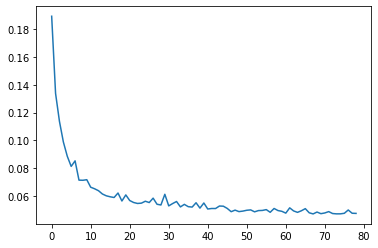

In [29]:
plt.plot(c)
plt.show()